<a href="https://colab.research.google.com/github/LNWork/Auslan-sign-app/blob/model/cameron_friend_copy_CNN_LSTM_model_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.saving import *
from matplotlib import pyplot as plt
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import glob
import json
import time

In [ ]:
import re
# test test test

def check_list_contained(A, B):
  # convert list A to string
    A_str = ' '.join(map(str, A))
    # convert list B to string
    B_str = ' '.join(map(str, B))
    # find all instances of A within B
    instances = re.findall(A_str, B_str)

    # return True if any instances were found, False otherwise
    return len(instances) > 0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
SSD_PATH = '/content/gdrive/MyDrive/Auslan App/Data'


In [ ]:
%cd $SSD_PATH
%pwd

/content/gdrive/.shortcut-targets-by-id/1tK1wFii8GBHvsqqcHbnxGWpOkelsFvzD/Auslan App/Data


'/content/gdrive/.shortcut-targets-by-id/1tK1wFii8GBHvsqqcHbnxGWpOkelsFvzD/Auslan App/Data'

In [ ]:
!unzip json_keypoints.zip -d /images_first_json

Archive:  json_keypoints.zip
   creating: /images_first_json/json_keypoints/
  inflating: /images_first_json/json_keypoints/1000_keypoints.json  
  inflating: /images_first_json/json_keypoints/1001_keypoints.json  
  inflating: /images_first_json/json_keypoints/1002_keypoints.json  
  inflating: /images_first_json/json_keypoints/1003_keypoints.json  
  inflating: /images_first_json/json_keypoints/1004_keypoints.json  
  inflating: /images_first_json/json_keypoints/1005_keypoints.json  
  inflating: /images_first_json/json_keypoints/1006_keypoints.json  
  inflating: /images_first_json/json_keypoints/1007_keypoints.json  
  inflating: /images_first_json/json_keypoints/1008_keypoints.json  
  inflating: /images_first_json/json_keypoints/1009_keypoints.json  
  inflating: /images_first_json/json_keypoints/100_keypoints.json  
  inflating: /images_first_json/json_keypoints/1010_keypoints.json  
  inflating: /images_first_json/json_keypoints/1011_keypoints.json  
  inflating: /images_first_

Need to get data in format of list of dataframe being the data where the index is same as label index.



In [ ]:
# Getting all the files for data
files = glob.glob('/images_first_json/json_keypoints/*')

# Getting the sheet of the signs
iso_sign_key = pd.read_excel('Isolated_Sign_Language_List.xlsx', index_col=None, usecols="B:D")

# check start time
start = time.time()

# Initialising the array for the test & train data
y_train = []
x_train = []

y_test = []
x_test = []

# Getting largest frames in the dataset to match all sizes
largest_frames = 0

# Going through all files
for file in files:
  # Getting JSON file
  with open(file, 'r') as f:
    # Reading JSON file and converting it to dict type
    d = f.read()
    vid_data = json.loads(d)

    # Getting video id to match with the name
    id = file.split("/")[-1].split('_')[0]
    id = 1 if id == "f'{video" else id # Checker for missing video id 1

    # Get Key points in dataframe format for the next step
    data = []
    for frame in vid_data:
        # Checks if not all the land_marks are there, skip frame if yes
        if not check_list_contained(['pose_landmarks', 'left_hand_landmarks', 'right_hand_landmarks'], frame.keys()):
          #print('failed', frame['frame'])
          continue

        # Appending whole frame data to the temp variable
        f_data = pd.DataFrame(frame['pose_landmarks'] + frame['left_hand_landmarks'] + frame['right_hand_landmarks'])
        data.append(f_data)

    if len(data) == 0:
      # print(f"No complete data for {id}")
      continue

    # Making the dataframes in the same format
    combined_df = pd.concat(data, ignore_index=True)
    reshaped_data = combined_df.values.reshape((len(data), 75, 4))

    # Checking for largest frame
    largest_frames = len(data) if len(data) > largest_frames else largest_frames

    # Read the csv for the label and which split is goes into
    iso_row = iso_sign_key.loc[iso_sign_key['Video_ID'] == int(id)]
    word = iso_row["Gloss"].values[0]

    # cbs createing val data, only checking for test
    if "test" in iso_row["Split"].values:
      y_test.append(word)
      x_test.append(reshaped_data)
    else:
      y_train.append(word)
      x_train.append(reshaped_data)

# Printing total data and total time run
print("Train", len(x_train), len(y_train))
print("Test", len(x_test), len(y_test))
print(time.time() - start)

Train 2522 2522
Test 587 587
36.967543601989746


In [ ]:
print(x_train[5].shape)
print(len(x_train))
print(largest_frames)

(13, 75, 4)
2522
136


In [ ]:
def pad_sequences(data, max_timesteps):
    padded_data = []

    for sequence in data:
        # Original shape: (timesteps, keypoints, 4)
        timesteps, keypoints, features = sequence.shape

        # Reshape the keypoints (75) into spatial dimensions for Conv3D
        height = 75  # Assuming a square grid-like reshaping, for example 15x5
        width = keypoints // height

        # Reshape sequence to fit into Conv3D: (timesteps, height, width, features)
        reshaped_sequence = sequence.reshape((timesteps, height, width, features))

        # Pad the sequence along the time axis (first dimension)
        padding_needed = max_timesteps - timesteps
        if padding_needed > 0:
            # Pad along the time dimension (axis 0)
            padded_sequence = np.pad(reshaped_sequence, ((0, padding_needed), (0, 0), (0, 0), (0, 0)), mode='constant')
        else:
            padded_sequence = reshaped_sequence

        padded_data.append(padded_sequence)

    # Convert to a numpy array and add the required extra channel dimension for Conv3D
    return np.array(padded_data)[..., np.newaxis]

# Pad train and test data
padded_train_data = pad_sequences(x_train, largest_frames)
padded_test_data = pad_sequences(x_test, largest_frames)

# padded_train_data = padded_train_data[..., np.newaxis]
# padded_test_data = padded_test_data[..., np.newaxis]

In [ ]:
# [Video [Frame [Keypoints]]]
print(padded_train_data.shape)
print(padded_test_data.shape)

timesteps, height, width, channels, outputs = padded_train_data.shape[1], padded_train_data.shape[2], padded_train_data.shape[3], padded_train_data.shape[4], 610


(2522, 136, 75, 1, 4, 1)
(587, 136, 75, 1, 4, 1)


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Encode the labels (train and test labels)
train_labels = label_encoder.transform(y_train)  # Assuming these are your training labels
test_labels = label_encoder.transform(y_test)  # Assuming this is your test label

# One-hot encode the labels for use in categorical crossentropy
train_labels = to_categorical(train_labels, num_classes=outputs)
test_labels = to_categorical(test_labels, num_classes=outputs)

In [ ]:
load_weights = "/content/gdrive/MyDrive/Auslan App/Data/frienddidit.keras"
# load_weights = None
if load_weights == None:
  # Define the model
  input_layer = Input(shape=(136, 75, 1, 4))  # Adjust shape based on your data

  # 3D Convolutional layers to extract features over time
  x = TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))(input_layer)
  x = TimeDistributed(BatchNormalization())(x)
  x = TimeDistributed(Flatten())(x)

  # LSTM for temporal processing
  x = Bidirectional(LSTM(128, return_sequences=False))(x)

  # Add Dropout for regularization
  x = Dropout(0.5)(x)

  # Fully connected layers for classification
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(610, activation='softmax')(x)  # Assuming 610 output classes

  # Create the final model
  final_model = Model(inputs=input_layer, outputs=output)

  # Compile the model with a lower learning rate
  final_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

  # Summary of the model
  final_model.summary()

else:
  final_model = load_model(filepath=load_weights)
  final_model.summary()



Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 136, 75, 1, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 136, 75, 1, 32)      │           1,184 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 136, 75, 1, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 136, 2400)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │       2,589,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 610)                 │         156,770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,440,584 (32.20 MB)

 Trainable params: 2,813,506 (10.73 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 5,627,014 (21.47 MB)

In [ ]:
# Callback Functions:

# 1. Early Stopping: Stops training when a monitored metric has stopped improving, which helps to avoid overfitting.
early_stopping = EarlyStopping (
    monitor = 'val_accuracy', # Monitor validation loss
    patience = 10, # Number of epochs with no improvement after which training will be stopped
    verbose = 1, # Print messages
    restore_best_weights = True # Restore model weights from the epoch with the best validation loss
)

# 2. Model Checkpoint: Saves the model at specific intervals or when it achieves the best performance on the validation set.
model_checkpoint = ModelCheckpoint(
    filepath = '/content/gdrive/MyDrive/Auslan App/Model/Checkpoints/camerondansbest_model.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

#3. Learning Rate Scheduler: Reduces the learning rate when the performance metric stops improving.
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2, # Factor by which the learning rate will be reduced
    patience = 10,
    verbose = 1
)

callbacks = [model_checkpoint]

In [ ]:
# Train model
history = final_model.fit(
    padded_train_data,
    train_labels,
    epochs=125,  # Adjust epochs based on your needs
    batch_size=8,  # You can adjust this depending on memory
    validation_data=(padded_test_data, test_labels),
    verbose=1,
    callbacks=callbacks
)

Epoch 1/125
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2998 - loss: 2.9928
Epoch 1: val_accuracy improved from -inf to 0.02555, saving model to /content/gdrive/MyDrive/Auslan App/Model/Checkpoints/camerondansbest_model.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.2997 - loss: 2.9929 - val_accuracy: 0.0256 - val_loss: 6.7726
Epoch 2/125
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3056 - loss: 2.9167
Epoch 2: val_accuracy improved from 0.02555 to 0.05111, saving model to /content/gdrive/MyDrive/Auslan App/Model/Checkpoints/camerondansbest_model.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.3056 - loss: 2.9170 - val_accuracy: 0.0511 - val_loss: 6.6997
Epoch 3/125
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2779 - loss: 2.9726
Epoch 3: val_accuracy did not improve from 0.05111
316/316 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.2779 - loss: 2.9728 - val_accuracy: 0.0426 - val_loss: 6.6166
Epoch 4/125
316/316

In [ ]:
# Evaluate on test data
final_model.evaluate(padded_test_data, test_labels)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0026 - loss: 6.5803


[6.5761284828186035, 0.003407154930755496]

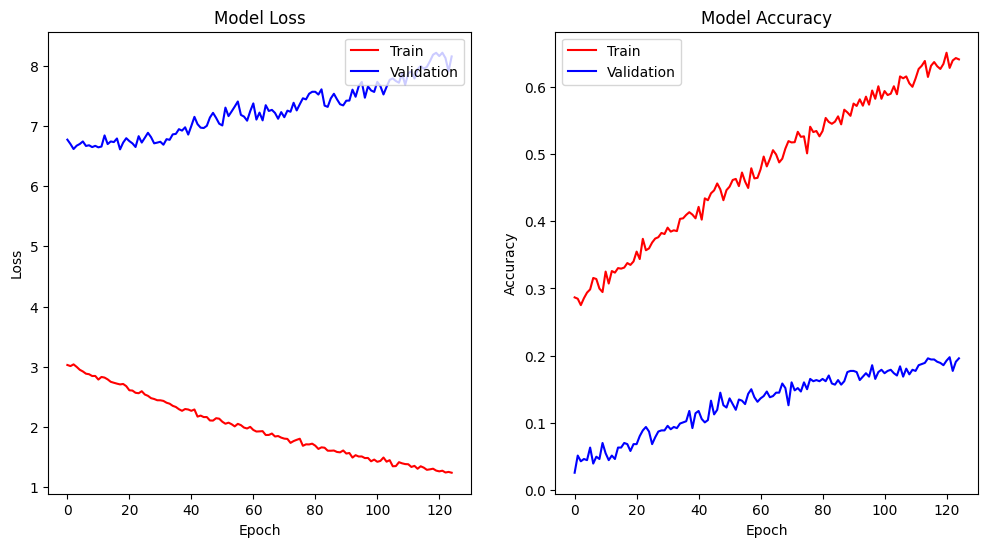

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
final_model.save('frienddidit_cam1_200_extra.keras')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the test data
y_pred = model.predict(padded_test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=words, yticklabels=words)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

KeyboardInterrupt: 